In [ ]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
def query_db(query):
    '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
    '''
    host = 'url'
    port = ####
    db = '###'
    username = '###'
    password = '###'
    conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    rows = pd.DataFrame(rows)
    return rows

### Challenge One: Data Analysis


##### 1) How many incidents were opened in each year (beginning with 2010)? 

In [ ]:
query_db("SELECT distinct(status) FROM public.three_one_one;")

,0
0,Pending
1,Draft
2,In Progress
3,Open
4,Closed - Testing
5,Started
6,Unassigned
7,Cancelled
8,Closed
9,Assigned


From above query, I figured out what kind of values does the column "STATUS" can take and hence now I will use status = open as a condition to filter out those incidents which are open for each year.

In [ ]:
df_inc = query_db("SELECT extract(year from created_date),COUNT(*) FROM public.three_one_one WHERE status = 'Open' and extract(year from created_date) >= 2010  GROUP BY extract(year from created_date) ORDER BY extract(year from created_date);")
df_inc.columns = ["Year","No. of Incidents"] #Renaming the columns for readability
df_inc

,Year,No. of Incidents
0,2010,32195
1,2011,122062
2,2012,28278
3,2013,23473
4,2014,18536
5,2015,22952
6,2016,28827
7,2017,25655
8,2018,20515
9,2019,35858


Hence from above query, we can see that for each year how many incidents were in open status.

##### 2) Which borough has the most incidents?

In [ ]:
df_borough = query_db("SELECT borough,count(*) as counts FROM public.three_one_one GROUP BY borough ORDER BY counts DESC ;")
df_borough.columns = ["Borough Name","No. of Incidents"] #Renaming the columns for readability
df_borough

,Borough Name,No. of Incidents
0,BROOKLYN,6342836
1,QUEENS,4865070
2,MANHATTAN,4134900
3,BRONX,3718699
4,Unspecified,1218678
5,STATEN ISLAND,1070930
6,,3


From above Query, it is clear that BROOKLYN has the most incidents.

### Challenge Two: Build a Data Product

##### Data Visualizations

###### 1) Top 5 Location_type having the most Incidents.

                Location_type  No. of Incidents
0        RESIDENTIAL BUILDING           5784609
1                                       5201731
2             Street/Sidewalk           2770314
3                      Street           2008619
4  Residential Building/House           1796405


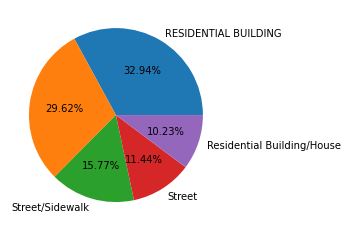

In [ ]:
df_loc_type = query_db("SELECT location_type,count(*) as counts FROM public.three_one_one GROUP BY location_type ORDER BY counts DESC LIMIT 5;")
df_loc_type.columns = ['Location_type', 'No. of Incidents']
print(df_loc_type)

plt.pie(df_loc_type['No. of Incidents'], labels = df_loc_type['Location_type'], autopct = '%1.2f%%')
plt.show() 

The above Pie Chart displays TOP 5 LOCATION_TYPE having the most Incidents.

We see that 33% of incidents were of type "Residential Building".

Followed by 29% with NO LOCATION_TYPE mentioned, this will be really helpful in model creation as we have identified rows which has no data.

###### 2) Bar Plot for each Borough reporting incident under Top 5 Location Type

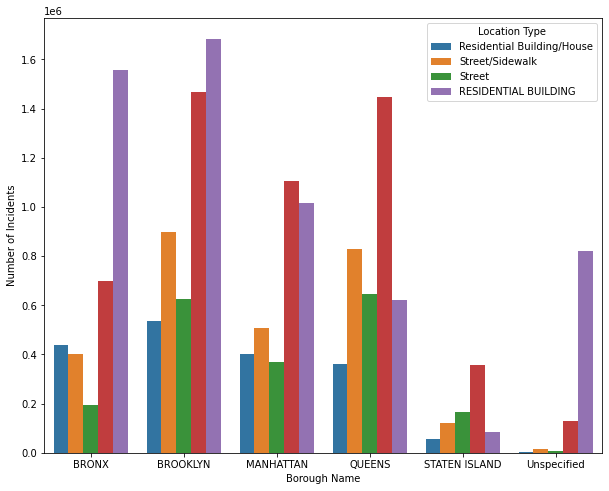

In [ ]:
df_bor_loc_type = query_db("select borough,location_type,count(*) as counts from public.three_one_one where location_type in ('RESIDENTIAL BUILDING','','Street/Sidewalk','Street','Residential Building/House') and borough != '' GROUP By borough,location_type ORDER BY borough;")
df_bor_loc_type.columns = ['Borough Name','Location Type',"Number of Incidents"]

plt.figure(figsize=(10, 8))
sns.barplot(x = df_bor_loc_type["Borough Name"],y = df_bor_loc_type["Number of Incidents"],data = df_bor_loc_type ,hue = df_bor_loc_type["Location Type"])

This gives us more detailed information about what kind of Location Type Incidents are reported at each Borough

###### 3) Top 10 Cities having the most Incidents.

            City  No. of Incidents
0       BROOKLYN           6402552
1       NEW YORK           4043299
2          BRONX           3783815
3                          1290052
4  STATEN ISLAND           1067695
5        JAMAICA            290792
6       FLUSHING            228063
7        Jamaica            221198
8        ASTORIA            196919
9       Flushing            155619


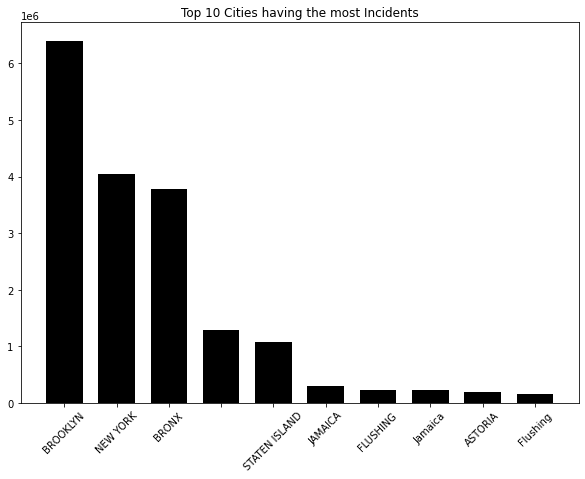

In [ ]:
df_city = query_db("SELECT city,count(*) as counts FROM public.three_one_one GROUP BY city ORDER BY counts DESC LIMIT 10;")
df_city.columns = ['City', 'No. of Incidents']
print(df_city)

fig = plt.figure(figsize =(10, 7))
plt.bar(df_city['City'],df_city['No. of Incidents'],color = 'black',width = 0.7)
plt.xticks(rotation = 45)
plt.title("Top 10 Cities having the most Incidents")
plt.show()

###### 4) Number of Incidents Yearly

In [ ]:
df_SR_submit = query_db("SELECT extract(year from created_date),COUNT(*) FROM public.three_one_one GROUP BY extract(year from created_date) ORDER BY extract(year from created_date);")
df_SR_submit.columns = ["Year","Number of Incidents"]
df_SR_submit

,Year,Number of Incidents
0,2010,2031813
1,2011,1961598
2,2012,1796207
3,2013,1839974
4,2014,2114000
5,2015,2300760
6,2016,2391426
7,2017,2491969
8,2018,2747985
9,2019,1675384


The above table shows how many incidents were created in each year.

Hence it is clear that the incidents were created from 2010 to 2019.

In [ ]:
df_inc_close = query_db("SELECT extract(year from closed_date),COUNT(*) FROM public.three_one_one WHERE status = 'Closed' GROUP BY extract(year from closed_date) ORDER BY extract(year from closed_date);")
df_inc_close.columns = ["Year","Closed Incidents"] #Renaming the columns for readability
df_inc_close

,Year,Closed Incidents
0,1899.0,1
1,1900.0,100
2,2010.0,1820782
3,2011.0,1786739
4,2012.0,1693500
5,2013.0,1755766
6,2014.0,2030335
7,2015.0,2212840
8,2016.0,2274232
9,2017.0,2380763


From above we can see that, No of incidents with Status as Closed starts from 1899 to 3027 and NaN values.

This means the data is inaccurate for some rows as on the website it is clearly mentioned, the Dataset is from 2010 to present (2021). 

Hence we are only going to consider rows from 2010 - 2021 for our Analysis and Model Preparation.

In [ ]:
df_valid_close = df_inc_close.loc[(df_inc_close.Year >= 2010) & (df_inc_close.Year < 2020)]
df_valid_close

,Year,Closed Incidents
2,2010.0,1820782
3,2011.0,1786739
4,2012.0,1693500
5,2013.0,1755766
6,2014.0,2030335
7,2015.0,2212840
8,2016.0,2274232
9,2017.0,2380763
10,2018.0,2644729
11,2019.0,1627497


Since the year 2020 was a complete lockdown, no incidents were reported and hence no SR would have been closed. Which is why I am neglecting the year 2020.

Also No Incidents were reported in 2021 as per the data.

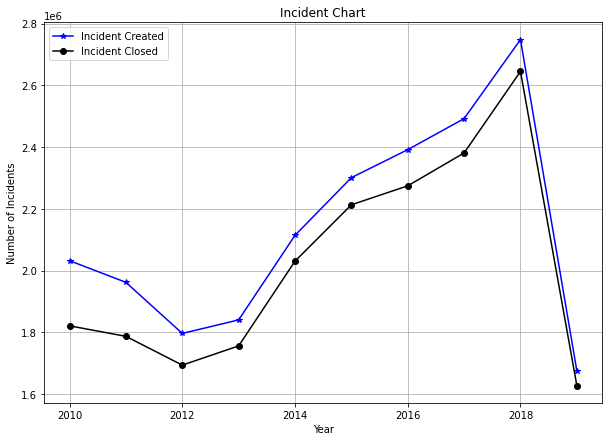

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.plot(df_SR_submit["Year"],df_SR_submit["Number of Incidents"],marker = "*",color = "blue",label = 'Incident Created')
plt.plot(df_valid_close["Year"],df_valid_close["Closed Incidents"],marker = "o",color = "black",label = 'Incident Closed')
plt.title("Incident Chart")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.legend()
plt.grid(True)
plt.show()

As we can see from the chart, as the number of Incident creation increases the number of incidents having status as closed also increases.

###### 5) Number of Incidents Created  Borough wise wrt to Year

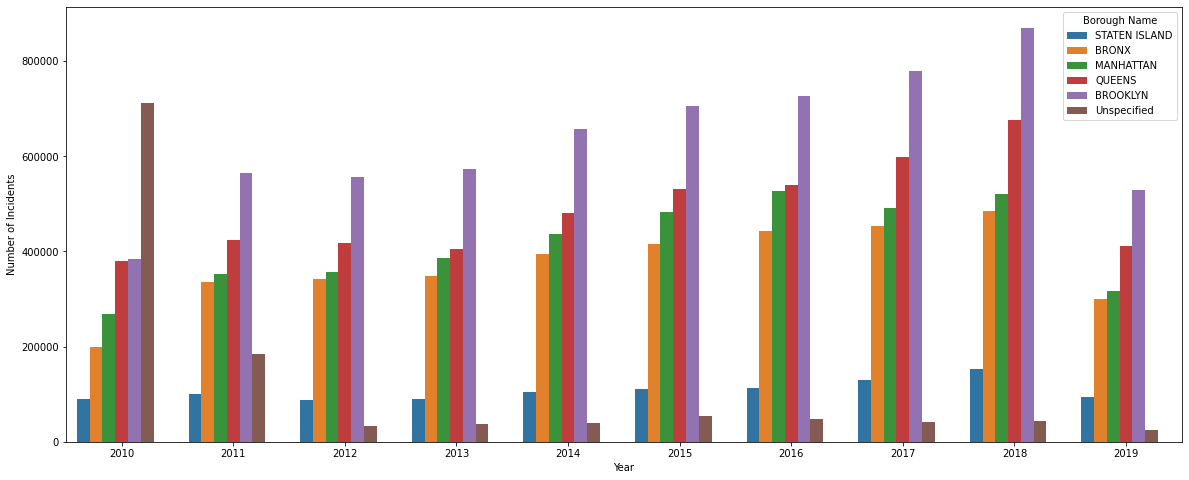

In [ ]:
df_bor_year_created = query_db("SELECT extract(year from created_date),borough,COUNT(*) as counts FROM public.three_one_one GROUP BY extract(year from created_date),borough ORDER BY extract(year from created_date),counts;")
df_bor_year_created.columns = ["Year","Borough Name","Number of Incidents"] 

plt.figure(figsize=(20, 8))
sns.barplot(x = df_bor_year_created["Year"],y = df_bor_year_created["Number of Incidents"],data = df_bor_year_created ,hue = df_bor_year_created["Borough Name"])

From the above chart we can see that Brooklyn has created the most incidents followed by Queens.

We can also see that Number of Unspecified Incidents kept on decreasing as people started mentioning Borough Name in their SR from 2011.

###### 6) Number of Incidents Closed  Borough wise wrt to Year

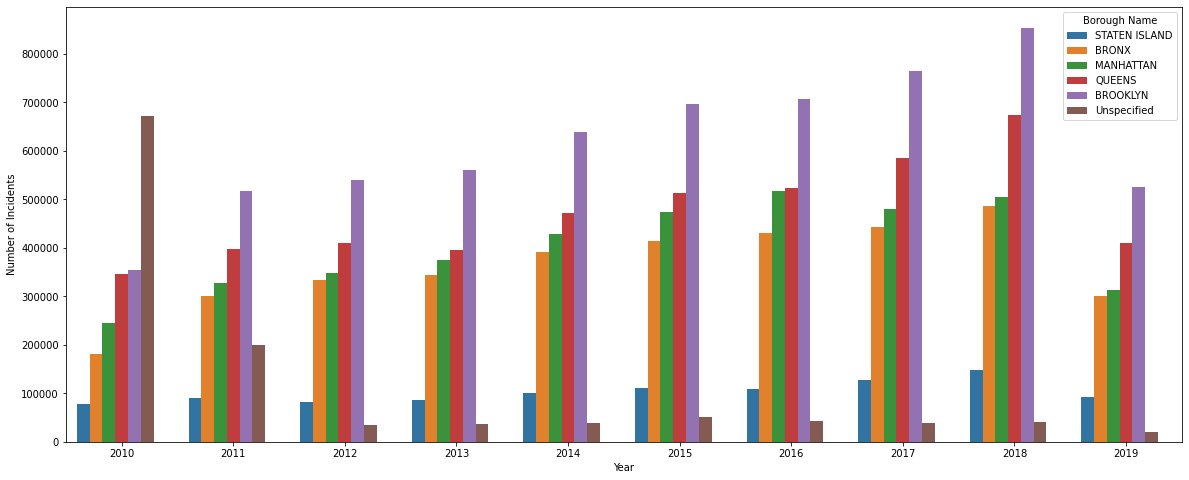

In [ ]:
df_bor_year_closed = query_db("SELECT extract(year from closed_date),borough,COUNT(*) as counts FROM public.three_one_one WHERE extract(year from closed_date) >= 2010 and extract(year from closed_date) < 2020 GROUP BY extract(year from closed_date),borough ORDER BY extract(year from closed_date),counts;")
df_bor_year_closed.columns = ["Year","Borough Name","Number of Incidents"] 

plt.figure(figsize=(20, 8))
sns.barplot(x = df_bor_year_closed["Year"],y = df_bor_year_closed["Number of Incidents"],data = df_bor_year_closed ,hue = df_bor_year_closed["Borough Name"])

We can see that Brooklyn has the most incidents closed followed by Queens.

It is since Brooklyn had the most incidents created, Brooklyn borough solves the most Incidents.

###### 7) Incident Type Submission

In [ ]:
df_inc_type = query_db("SELECT open_data_channel_type,count(*) as counts FROM public.three_one_one GROUP BY open_data_channel_type ORDER BY counts ;")
df_inc_type.columns = ["Type","Number of Incidents"]
df_inc_type

,Type,Number of Incidents
0,Unspecif,1
1,BRONX,2
2,OTHER,366674
3,MOBILE,1298129
4,ONLINE,3295109
5,UNKNOWN,5272356
6,PHONE,11118845


Since "Unspecific" and "BRONX" has very neglible incidents as compared to others, we can safely not consider them for our visualization.

In [ ]:
df_new_inc_type = df_inc_type.loc[2:6]
df_new_inc_type

,Type,Number of Incidents
2,OTHER,366674
3,MOBILE,1298129
4,ONLINE,3295109
5,UNKNOWN,5272356
6,PHONE,11118845


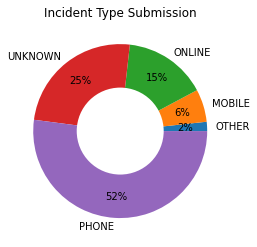

In [ ]:
# Pie Chart
plt.pie(df_new_inc_type["Number of Incidents"] ,labels = df_new_inc_type["Type"], autopct = '%1.0f%%', pctdistance=0.75)

# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
plt.title("Incident Type Submission")
plt.show()

From the Donut Chart we can see that 52% of SR submission was done via Phone.

###### 8) Complaint Type submitted by each Borough

In [ ]:
df_com_type = query_db("SELECT borough,complaint_type, count(*) as counts, DENSE_RANK() over (partition by borough ORDER BY counts DESC) FROM public.three_one_one GROUP BY borough,complaint_type ORDER BY borough,counts DESC ;")
df_com_type.columns = ["Borough Name","Complaint_type","Number of Incidents","Rank"]
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_com_type)

,Borough Name,Complaint_type,Number of Incidents,Rank
0,,Graffiti,2,1
1,,Consumer Complaint,1,2
2,BRONX,Noise - Residential,427473,1
3,BRONX,HEAT/HOT WATER,373859,2
4,BRONX,HEATING,195284,3
5,BRONX,Street Light Condition,179128,4
6,BRONX,PLUMBING,176849,5
7,BRONX,Blocked Driveway,145177,6
8,BRONX,UNSANITARY CONDITION,131550,7
9,BRONX,Water System,114137,8


In [ ]:
df_com_type[(df_com_type.Rank == 1) | (df_com_type.Rank == 2) ]

,Borough Name,Complaint_type,Number of Incidents,Rank
0,,Graffiti,2,1
1,,Consumer Complaint,1,2
2,BRONX,Noise - Residential,427473,1
3,BRONX,HEAT/HOT WATER,373859,2
262,BROOKLYN,Noise - Residential,515253,1
263,BROOKLYN,HEAT/HOT WATER,351816,2
537,MANHATTAN,Noise - Residential,383788,1
538,MANHATTAN,HEAT/HOT WATER,260335,2
817,QUEENS,Blocked Driveway,353496,1
818,QUEENS,Noise - Residential,341076,2


This gives us information about which Borough has what type of Complaint_type the most.

###### 9) Average Days for SR to close for Location Type incidents

In [ ]:
df_bor_days = query_db("select borough,location_type,AVG(Date(closed_date) - Date(created_date)) as days from public.three_one_one where borough != '' GROUP By borough,location_type ORDER BY borough,days;")
df_bor_days.columns = ["Borough","Location Type","Days"]
df_bor_days

,Borough,Location Type,Days
0,BRONX,Medical Facility,-40831.0
1,BRONX,School - College/University,-40761.0
2,BRONX,Nursing Home,-40713.0
3,BRONX,School - K-12 Public,-40597.0
4,BRONX,Homeless Shelter,-40570.0
...,...,...,...
889,Unspecified,School/Pre-School,NaN
890,Unspecified,Public School,NaN
891,Unspecified,Mobile Food Vendor,NaN
892,Unspecified,Soup Kitchen,NaN


Since our Database has incorrect values for Closed Date as we had seen above, hence we will discard those rows having negative values.

The Days with 0 indicates that SR was closed on the same day.

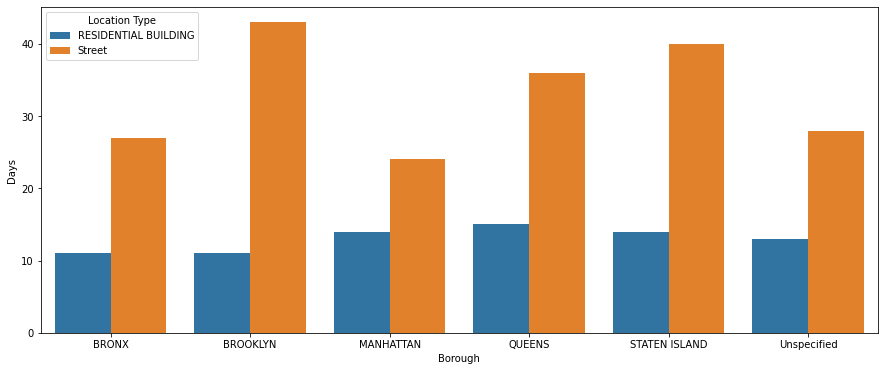

In [ ]:
df_bor_days = df_bor_days[df_bor_days.Days > 0]

df_bor_days = df_bor_days[(df_bor_days["Location Type"] == 'RESIDENTIAL BUILDING') | (df_bor_days["Location Type"] == 'Street/Sidewalk') | (df_bor_days["Location Type"] == 'Street') | (df_bor_days["Location Type"] == 'Residential Building/House')]

plt.figure(figsize=(15, 6))
sns.barplot(x = df_bor_days["Borough"],y = df_bor_days["Days"],data = df_bor_days ,hue = df_bor_days["Location Type"])

On an Average in BRONX Borough, the Street Location Type Incidents gets closed in approx 25 days and for Residential Building the SR gets closed in 10 Days.

###### 10) Top Cities Average SR closing time

In [ ]:
df_city_days = query_db("select city,AVG(Date(closed_date) - Date(created_date)) as days from public.three_one_one GROUP By city ORDER BY city,days;")
df_city_days.columns = ["City","Days"]
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_city_days)

,City,Days
0,,8.0
1,#200 BREA,16.0
2,*,16.0
3,.,17.0
4,/,16.0
5,/A,12.0
6,0,42.0
7,00,17.0
8,000,18.0
9,0000,7.0


In [ ]:
df_new_city_days = pd.merge(df_city_days,df_city,how = 'inner')
df_new_city_days = df_new_city_days[df_new_city_days.Days > 0]
df_new_city_days

,City,Days,No. of Incidents
0,,8.0,1290052
2,BRONX,3.0,3783815
3,BROOKLYN,4.0,6402552
5,Flushing,26.0,155619
7,Jamaica,21.0,221198
9,STATEN ISLAND,4.0,1067695


Removed Days with negative values as our Database has incorrect values.

Hence on an Average BRONX solves the SR in 3 Days.

Model Creation

In [ ]:
df_all = query_db("select Date(closed_date) - Date(created_date) as Days,incident_zip,agency,complaint_type,city,borough from public.three_one_one where extract(year from created_date) > 2016;")
df_all

,0,1,2,3,4,5
0,4.0,10467.0,HPD,ELECTRIC,BRONX,BRONX
1,0.0,11106.0,DOF,DOF Property - Reduction Issue,ASTORIA,QUEENS
2,1.0,11419.0,DEP,Sewer,South Richmond Hill,QUEENS
3,0.0,10465.0,DSNY,Sanitation Condition,BRONX,BRONX
4,0.0,10022.0,DOT,Street Condition,NEW YORK,MANHATTAN
...,...,...,...,...,...,...
6915333,NaN,11229.0,NYPD,Noise - Street/Sidewalk,BROOKLYN,BROOKLYN
6915334,NaN,11102.0,NYPD,Noise - Street/Sidewalk,ASTORIA,QUEENS
6915335,NaN,11214.0,NYPD,Illegal Parking,BROOKLYN,BROOKLYN
6915336,NaN,10031.0,NYPD,Noise - Street/Sidewalk,NEW YORK,MANHATTAN


In [ ]:
df_all.columns = ["Days","Zip Code","Agency","Complaint Type","City","Borough"]
df_all

,Days,Zip Code,Agency,Complaint Type,City,Borough
0,4.0,10467.0,HPD,ELECTRIC,BRONX,BRONX
1,0.0,11106.0,DOF,DOF Property - Reduction Issue,ASTORIA,QUEENS
2,1.0,11419.0,DEP,Sewer,South Richmond Hill,QUEENS
3,0.0,10465.0,DSNY,Sanitation Condition,BRONX,BRONX
4,0.0,10022.0,DOT,Street Condition,NEW YORK,MANHATTAN
...,...,...,...,...,...,...
6915333,NaN,11229.0,NYPD,Noise - Street/Sidewalk,BROOKLYN,BROOKLYN
6915334,NaN,11102.0,NYPD,Noise - Street/Sidewalk,ASTORIA,QUEENS
6915335,NaN,11214.0,NYPD,Illegal Parking,BROOKLYN,BROOKLYN
6915336,NaN,10031.0,NYPD,Noise - Street/Sidewalk,NEW YORK,MANHATTAN


In [ ]:
df_all = df_all.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
df_all.isna().sum()

Days              218882
Zip Code          303022
Agency                 0
Complaint Type         0
City              323159
Borough                3
dtype: int64

In [ ]:
df_all = df_all.dropna() # Dropping the Null Values
df_all.isna().sum()

Days              0
Zip Code          0
Agency            0
Complaint Type    0
City              0
Borough           0
dtype: int64

In [ ]:
df_all

,Days,Zip Code,Agency,Complaint Type,City,Borough
0,4.0,10467.0,HPD,ELECTRIC,BRONX,BRONX
1,0.0,11106.0,DOF,DOF Property - Reduction Issue,ASTORIA,QUEENS
2,1.0,11419.0,DEP,Sewer,South Richmond Hill,QUEENS
3,0.0,10465.0,DSNY,Sanitation Condition,BRONX,BRONX
4,0.0,10022.0,DOT,Street Condition,NEW YORK,MANHATTAN
...,...,...,...,...,...,...
6915249,1.0,10035.0,NYPD,Noise - Street/Sidewalk,NEW YORK,MANHATTAN
6915260,1.0,10474.0,NYPD,Noise - Residential,BRONX,BRONX
6915272,1.0,11249.0,NYPD,Noise - Residential,BROOKLYN,BROOKLYN
6915273,1.0,11378.0,NYPD,Illegal Parking,MASPETH,QUEENS


In [ ]:
df_all.Days.value_counts().tail(5)

-222.0     1
 853.0     1
-57.0      1
-6208.0    1
 850.0     1
Name: Days, dtype: int64

In [ ]:
df_all = df_all[df_all["Days"] > 0]


In [ ]:
df_all.Days.value_counts().tail(5)

858.0      1
860.0      1
865.0      1
871.0      1
69434.0    1
Name: Days, dtype: int64

In [ ]:
df_all["Complaint Type"].unique()

array(['ELECTRIC', 'Sewer', 'GENERAL', 'DOOR/WINDOW', 'HEAT/HOT WATER',
       'DOF Property - Payment Issue', 'Noise', 'Street Condition',
       'Water System', 'Missed Collection (All Materials)',
       'Sanitation Condition', 'Sidewalk Condition',
       'Housing - Low Income Senior', 'DOF Property - Reduction Issue',
       'PLUMBING', 'Food Establishment', 'Electronics Waste',
       'PAINT/PLASTER', 'Blocked Driveway', 'Snow',
       'Street Sign - Dangling', 'Other Enforcement', 'Illegal Parking',
       'Noise - Residential', 'Building/Use', 'APPLIANCE', 'Elevator',
       'Request Large Bulky Item Collection', 'Broken Parking Meter',
       'Root/Sewer/Sidewalk Condition', 'General Construction/Plumbing',
       'UNSANITARY CONDITION', 'WATER LEAK', 'FLOORING/STAIRS', 'SCRIE',
       'Derelict Vehicle', 'Air Quality',
       'Construction Safety Enforcement', 'DRIE', 'SAFETY',
       'Water Quality', 'Street Light Condition',
       'Maintenance or Facility', 'Special Operat

Since we have so many complaint type, we need to narrow our complaint type inorder for our model to detect positively.

In [ ]:
df_all.loc[(df_all['Complaint Type'] == 'WATER LEAK') | (df_all['Complaint Type'] == 'HEAT/HOT WATER') | (df_all['Complaint Type'] == 'Water System') | (df_all['Complaint Type'] == 'Water Conservation') | (df_all['Complaint Type'] == 'Water Quality') | (df_all['Complaint Type'] == 'Cooling Tower') | (df_all['Complaint Type'] == 'Boilers') | (df_all['Complaint Type'] == 'Drinking Water') | (df_all['Complaint Type'] == 'Standing Water') | (df_all['Complaint Type'] == 'Drinking') | (df_all['Complaint Type'] == 'Bottled Water'), ['Complaint Type',]] = 'Water Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'] == 'Street Condition') | (df_all['Complaint Type'] == 'Street Light Condition') | (df_all['Complaint Type'] == 'Sidewalk Condition') | (df_all['Complaint Type'] == 'Vacant Lot') | (df_all['Complaint Type'] == 'Root/Sewer/Sidewalk Condition') | (df_all['Complaint Type'] == 'Street Sign - Damaged') | (df_all['Complaint Type'] == 'Street Sign - Dangling') | (df_all['Complaint Type'] == 'Street Sign - Missing') | (df_all['Complaint Type'] == 'Public Payphone Complaint') | (df_all['Complaint Type'] == 'Highway Condition') | (df_all['Complaint Type'] == 'Highway Sign - Damaged')| (df_all['Complaint Type'] == 'Highway Sign - Missing') | (df_all['Complaint Type'] == 'Highway Sign - Dangling') | (df_all['Complaint Type'] == 'DEP Highway Condition') | (df_all['Complaint Type'] == 'DEP Sidewalk Condition') | (df_all['Complaint Type'] == 'DEP Street Condition'), ['Complaint Type',]] = 'Street Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('DOF')), ['Complaint Type',]] = 'DOF Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Noise')), ['Complaint Type',]] = 'Noise Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Vehicle')) | (df_all['Complaint Type'].str.contains('Bus')) | (df_all['Complaint Type'].str.contains('Taxi')) | (df_all['Complaint Type'].str.contains('Bike'))  , ['Complaint Type']] = 'Vehicle Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.match('Plumbing')) | (df_all['Complaint Type'].str.match('PLUMBING')), ['Complaint Type']] = 'Plumbing Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Parking')), ['Complaint Type']] = 'Parking Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Bulky')), ['Complaint Type']] = 'Bulky Item Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Unsanitary')) | (df_all['Complaint Type'].str.contains('UNSANITARY')) | (df_all['Complaint Type'].str.contains('Sanitation')) | (df_all['Complaint Type'].str.match('Dirty')), ['Complaint Type']] = 'Unsanitary Condition'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('PAINT')) , ['Complaint Type']] = 'Paint Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.match('Electric')) , ['Complaint Type']] = 'Electric Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.match('Animal')) , ['Complaint Type']] = 'Animal Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Tree')) , ['Complaint Type']] = 'Tree Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all.loc[(df_all['Complaint Type'].str.contains('Traffic')) , ['Complaint Type']] = 'Traffic Complaint'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_all["Complaint Type"].value_counts().head(10)

Water Complaint                      716601
Noise Complaint                      432197
Unsanitary Condition                 389261
Street Complaint                     386505
Bulky Item Complaint                 310775
Plumbing Complaint                   148608
Paint Complaint                      144595
Tree Complaint                       128537
Parking Complaint                    113832
Missed Collection (All Materials)     94138
Name: Complaint Type, dtype: int64

In [ ]:
final_df = df_all.loc[(df_all["Complaint Type"] == "Noise Complaint") | (df_all["Complaint Type"] == "Water Complaint") | (df_all["Complaint Type"] == "Street Complaint")| (df_all["Complaint Type"] == "Parking Complaint") | (df_all["Complaint Type"] == "Unsanitary Condition")| (df_all["Complaint Type"] == "Tree Complaint") | (df_all["Complaint Type"] == "Bulky Item Complaint") | (df_all["Complaint Type"] == "Vehicle Complaint") | (df_all["Complaint Type"] == "Plumbing Complaint") | (df_all["Complaint Type"] == "Paint Complaint")]
final_df

,Days,Zip Code,Agency,Complaint Type,City,Borough
10,2.0,11105.0,HPD,Water Complaint,Astoria,QUEENS
12,27.0,11205.0,DEP,Noise Complaint,BROOKLYN,BROOKLYN
14,1.0,11367.0,DOT,Street Complaint,Flushing,QUEENS
15,1.0,11224.0,DEP,Water Complaint,BROOKLYN,BROOKLYN
18,3.0,11210.0,DSNY,Unsanitary Condition,BROOKLYN,BROOKLYN
...,...,...,...,...,...,...
6915247,1.0,10019.0,NYPD,Noise Complaint,NEW YORK,MANHATTAN
6915249,1.0,10035.0,NYPD,Noise Complaint,NEW YORK,MANHATTAN
6915260,1.0,10474.0,NYPD,Noise Complaint,BRONX,BRONX
6915272,1.0,11249.0,NYPD,Noise Complaint,BROOKLYN,BROOKLYN


In [ ]:
final_df["City"].value_counts().head(11)

BROOKLYN         886656
BRONX            593895
NEW YORK         545333
STATEN ISLAND    148304
Jamaica           44254
Flushing          34329
Astoria           31202
Ridgewood         29766
JAMAICA           20975
Elmhurst          17892
ASTORIA           17457
Name: City, dtype: int64

In [ ]:
final_df.loc[(final_df['City'].str.contains('JAMAICA')) , ['City']] = 'Jamaica'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
final_df.loc[(final_df['City'].str.contains('FLUSHING')) , ['City']] = 'Flushing'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
final_df.loc[(final_df['City'].str.contains('ASTORIA')) , ['City']] = 'Astoria'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
final_df.loc[(final_df['City'].str.contains('RIDGEWOOD')) , ['City']] = 'Ridgewood'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
final_df["City"].value_counts().head(5)

BROOKLYN         886656
BRONX            593895
NEW YORK         545333
STATEN ISLAND    148304
Jamaica           65229
Name: City, dtype: int64

In [ ]:
final_df = final_df.loc[(df_all["City"] == "BROOKLYN") | (df_all["City"] == "BRONX") | (df_all["City"] == "NEW YORK")| (df_all["City"] == "STATEN ISLAND") | (df_all["City"] == "Jamaica")]
final_df

,Days,Zip Code,Agency,Complaint Type,City,Borough
12,27.0,11205.0,DEP,Noise Complaint,BROOKLYN,BROOKLYN
15,1.0,11224.0,DEP,Water Complaint,BROOKLYN,BROOKLYN
18,3.0,11210.0,DSNY,Unsanitary Condition,BROOKLYN,BROOKLYN
20,7.0,11208.0,DOT,Street Complaint,BROOKLYN,BROOKLYN
25,29.0,11230.0,HPD,Plumbing Complaint,BROOKLYN,BROOKLYN
...,...,...,...,...,...,...
6915227,1.0,11237.0,NYPD,Parking Complaint,BROOKLYN,BROOKLYN
6915247,1.0,10019.0,NYPD,Noise Complaint,NEW YORK,MANHATTAN
6915249,1.0,10035.0,NYPD,Noise Complaint,NEW YORK,MANHATTAN
6915260,1.0,10474.0,NYPD,Noise Complaint,BRONX,BRONX


In [ ]:
X = final_df.drop(["Complaint Type"],axis = 1)
y = final_df["Complaint Type"]

In [ ]:
X = pd.get_dummies(X,drop_first=True)
X

,Days,Zip Code,Agency_DOB,Agency_DOHMH,Agency_DOITT,Agency_DOT,Agency_DPR,Agency_DSNY,Agency_EDC,Agency_HPD,Agency_NYPD,Agency_TLC,City_BROOKLYN,City_Jamaica,City_NEW YORK,City_STATEN ISLAND,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Borough_Unspecified
12,27.0,11205.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
15,1.0,11224.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
18,3.0,11210.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
20,7.0,11208.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
25,29.0,11230.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6915227,1.0,11237.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
6915247,1.0,10019.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
6915249,1.0,10035.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
6915260,1.0,10474.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [ ]:
y_test.value_counts()

Water Complaint         184359
Noise Complaint         107219
Unsanitary Condition     96088
Street Complaint         77774
Bulky Item Complaint     58436
Paint Complaint          39440
Plumbing Complaint       39381
Tree Complaint           23621
Parking Complaint        21577
Vehicle Complaint        17638
Name: Complaint Type, dtype: int64

###### Model Creation

In [ ]:
def plot_cm(algo,x,y):
  fig, ax = plt.subplots(figsize=(20, 10))

  plot_confusion_matrix(algo, x, y,labels=['Water Complaint','Noise Complaint','Unsanitary Condition','Street Complaint','Bulky Item Complaint','Plumbing Complaint','Paint Complaint','Tree Complaint','Parking Complaint','Vehicle Complaint'],ax=ax)  
  plt.show()


###### Creating Gradient Boosting Classifier

In [ ]:
clf = GradientBoostingClassifier(max_features='auto')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test,pred))
joblib.dump(clf,"GB.h5")

Accuracy: 0.7283485567207035


['GB.h5']

###### Model Validation using Confusion Matrix for Gradient Boosting CLassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


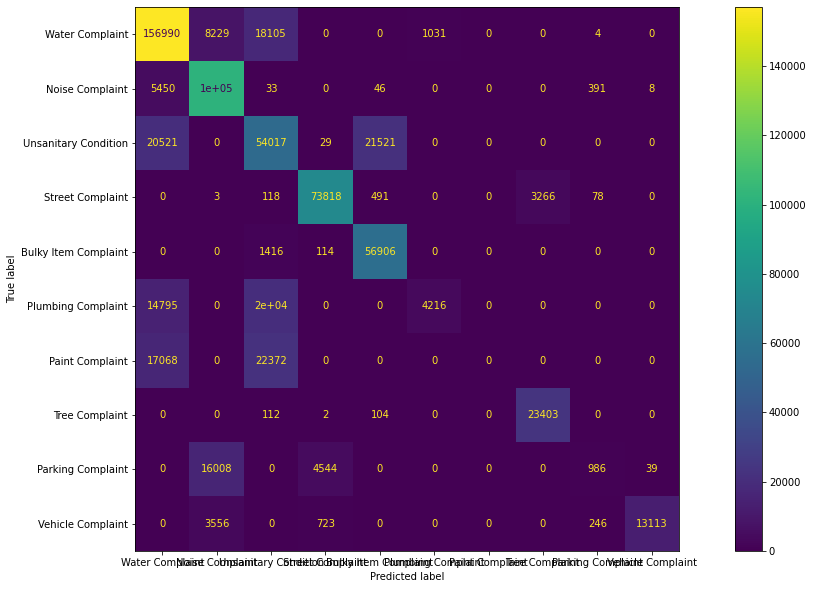

In [ ]:
# Model Validation

plot_cm(clf,X_test,y_test)

###### Grid Search CV for Random Forest Classifier

In [ ]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_depth' : [4,5,6],
#     'criterion' :['gini', 'entropy']
#   }

# gsv_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 3,n_jobs=-1)
# gsv_rfc.fit(X_train, y_train)
# print(gsv_rfc.score(X_train, y_train))
# print(gsv_rfc.best_params_)

###### Creating the Model Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
pred_rf = rf.predict(X_test)
print("Accuracy:",accuracy_score(y_test,pred_rf))
joblib.dump(rf,"RF.h5")

Accuracy: 0.7306790196729539


['RF.h5']

Validation using Confusion Matrix for Random Forest Classifier 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


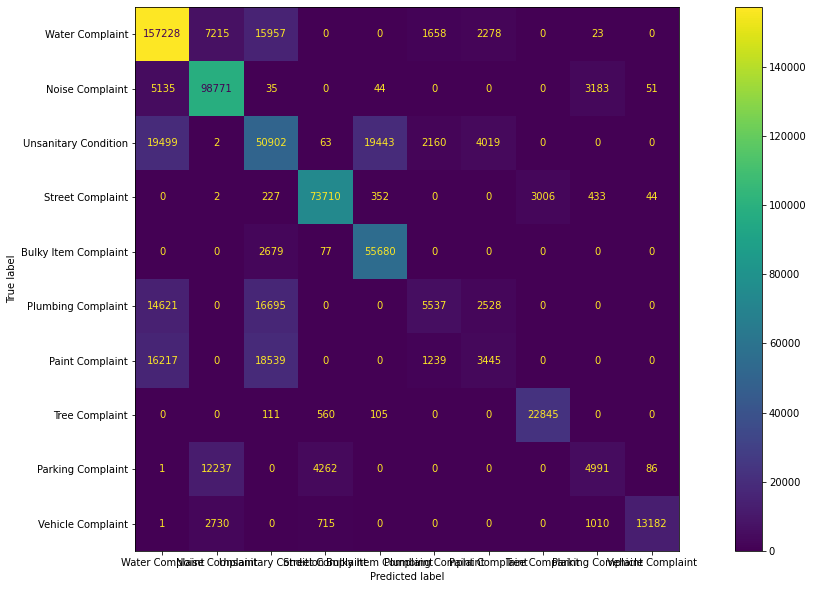

In [ ]:
# Model Validation

plot_cm(rf, X_test, y_test)